In [3]:
import geopandas as gpd
from matplotlib import pyplot as plt

In [4]:
# gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
# tiles_df = gpd.read_file('output/covering_tiles.kml', driver='KML')
tiles_df = gpd.read_file('output/covering_tiles.json')
print(repr(tiles_df.crs))
print(tiles_df)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

     TileName                                           geometry
0       10UGU  POLYGON Z ((-120.28118 48.72093 0.00000, -118....
1       11TLN  POLYGON Z ((-119.67207 47.82260 0.00000, -118....
2       11ULP  POLYGON Z ((-119.71936 48.72091 0.00000, -118....
3       12TUM  POLYGON Z ((-113.43120 42.42690 0.00000, -112....
4       12TVM  POLYGON Z ((-112.21648 42.44624 0.00000, -110....
...       ...                                                ...
1179    36JTR  POLYGON Z ((29.99818 -26.18805 0.00000, 31.096...
1180    53HPB  POLYGON Z ((136.08714 -34.33630 0.00000, 137.2...
1181    54HUH  POLYGON Z ((138.84898 -33.42038 0.00000, 140.0...
1182    55HCV  POLYGON Z ((144.77762 -36

In [12]:
import shapely.ops as shops
import shapely.geometry as shgeom
import shapely.affinity as shaff
import time


ax = None
def plot_geom(geom, **kwargs):
    """
    Plot geom on the global axis.
    """
    assert ax is not None
    gpd.GeoSeries(geom).plot(ax=ax, **kwargs)

def split_1d(geom, n, direction, debug=False):
    """
    Split geom n times in a given direction.
    Return the splitted geometries.
    Follows method in https://stackoverflow.com/q/58283684.

    Given this square:
    1 --> 2
    ^     |
    |     v
    0 <-- 3

    left -> right: lerp 0, 1 -> 3, 2
    top -> down: lerp 1, 2 -> 0, 3
    """
    coords = list(shgeom.Point(c) for c in geom.exterior.coords)
    if len(coords) == 5:
        for i, c in enumerate(coords):
            if i == len(coords)-1:
                d = coords[0]
            else:
                d = coords[i+1]
            if c == d:
                if debug: print('Remove', i)
                del coords[i]
                break
    assert len(coords) == 4

    # rotate linear ring so that coords[0] is the bottom left
    # assumes geometry only has one point in quadrant III
    def offset_from_centroid(geom, c):
        return shaff.translate(c, -geom.centroid.x, -geom.centroid.y)
    min_coord_i = 0
    for i, c in enumerate(coords):
        off = offset_from_centroid(geom, c)
        if off.x < 0 and off.y < 0:
            min_coord_i = i
            if debug: print('Rotate', i, 'to first index')
    coords = coords[min_coord_i:] + coords[:min_coord_i]

    # Assume the following:
    # 1. 4 coordinates are the 4 bounds of the rectangle
    # 2. Coordinates are in a linear ring
    # 3. Bottom left coordinate is at coords[0]

    if debug:
        # plot linear ring
        for i, c in enumerate(coords):
            plot_geom(c, color=(0, 0, 1, (i+1)/len(coords)))

    # lerp from a to b, n times
    splitters = []
    if direction == 'left_right':
        ls_a = shgeom.LineString((coords[0], coords[3]))
        ls_b = shgeom.LineString((coords[1], coords[2]))
    elif direction == 'top_down':
        ls_a = shgeom.LineString((coords[1], coords[0]))
        ls_b = shgeom.LineString((coords[2], coords[3]))
    else:
        raise NotImplementedError(direction)
    # test that top and bot are correctly named
    if debug:
        plot_geom(ls_a, color='red')
        plot_geom(ls_b, color='green')
    
    extend_percent = 0.2  # how much to extend the line
    for i in range(1, n):
        # lerp along the line
        lerp_percent = i / n
        interp_a_ls = ls_a.interpolate(lerp_percent, normalized=True)
        interp_b_ls = ls_b.interpolate(lerp_percent, normalized=True)

        # extend the line by a portion to account for floating point precision
        new_interp_a_ls = shgeom.Point(
            (interp_a_ls.x - ((interp_b_ls.x - interp_a_ls.x) * extend_percent)),
            (interp_a_ls.y - ((interp_b_ls.y - interp_a_ls.y) * extend_percent))
            )
        new_interp_b_ls = shgeom.Point(
            (interp_b_ls.x - ((interp_a_ls.x - interp_b_ls.x) * extend_percent)),
            (interp_b_ls.y - ((interp_a_ls.y - interp_b_ls.y) * extend_percent))
            )
        if debug:
            plot_geom(new_interp_a_ls, color=(1, 0, 0, lerp_percent))
            plot_geom(new_interp_b_ls, color=(0, 1, 0, lerp_percent))
        
        # create a new LineString which will split geom
        split_ls = shgeom.LineString((new_interp_b_ls, new_interp_a_ls))
        splitters.append(split_ls)

    # split geom using all the splitters.
    # this assumes ordering of the splitters (left -> right, up -> down)...
    # and will fail if the ordering is messed up
    splits = []
    q = geom
    for i, splitter in enumerate(splitters):
        if debug:
            plot_geom(q, color=(0, 0, 0, 0), edgecolor=(0, 0, 1), hatch='o')
            plot_geom(splitter, color=(0, 0, 1))
        split_result = shops.split(q, splitter)
        if len(split_result) == 2:
            p, q = split_result
            splits.append(p)
        else:
            # the geometry was not split by the splitter, blurt diagnostics
            if splitter.intersects(q):
                print('line intersects but does not split')
            else:
                print('line does not intersect')
            raise Exception(f'iteration {i} {len(split_result)=}')
    splits.append(q)
    return splits


def split_2d(geom, n, return_list=False):
    """
    """
    small_tiles = []  # results of splitting, in a 1d array
    splits = split_1d(geom, n, 'left_right')
    for s in splits:
        s_split = split_1d(s, n, 'top_down')
        small_tiles += s_split
    if return_list:
        return small_tiles
    else:
        return shgeom.MultiPolygon(small_tiles)

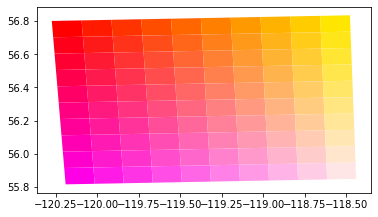

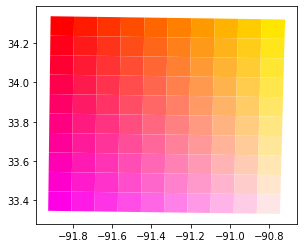

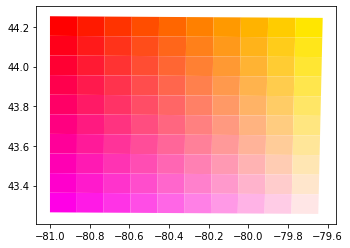

Average time: 0.08092705408732097


In [13]:
# Plot some 2d splits
times = []
n = 10
for tile_i, tile_geom in enumerate(tiles_df.geometry.sample(3)):
    # can't be assed to axis-align the box, so just do two separate lerps
    small_tiles = []  # results of splitting, in a 1d array
    begin = time.time()
    small_tiles = split_2d(tile_geom, n, return_list=True)
    end = time.time()
    times.append(end-begin)
    
    # plot the results
    ax = plt.gca()
    for i in range(n):
        for j in range(n):
            plot_geom(small_tiles[i*n+j], color=(1, i/n, j/n))
    plt.show()
print('Average time:', sum(times)/len(times))

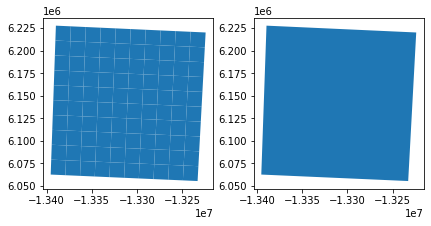

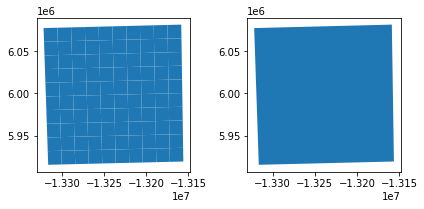

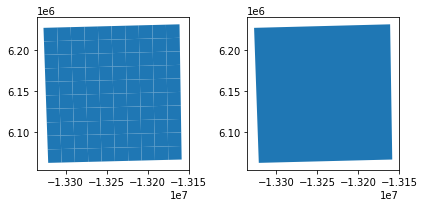

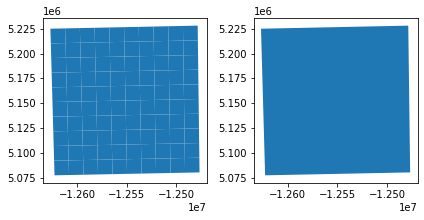

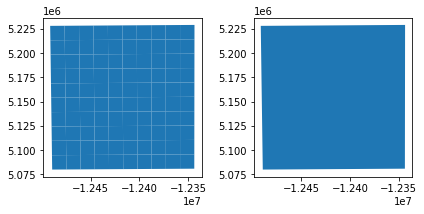

In [17]:
tiles_df_10 = tiles_df.copy()
tiles_df_10_geometry = tiles_df_10.to_crs('EPSG:3857').geometry.head(5).progress_apply(split_2d, n=10)
for i in range(5):
    fig, axs = plt.subplots(1, 2)
    gpd.GeoSeries(tiles_df_10_geometry[i]).plot(ax=axs[0])
    gpd.GeoSeries(tiles_df.to_crs('EPSG:3857').geometry[i]).plot(ax=axs[1])
    fig.tight_layout()

In [16]:
# Apply splits to df
from tqdm.notebook import tqdm
tqdm.pandas()
def split_df(df, n):
    new_df = df.copy()
    new_df.geometry = new_df.geometry.progress_apply(split_2d, n=n)
    new_df = new_df.explode()
    new_df = new_df.reset_index(1).rename(columns={"level_1": "InnerTileIndex"})
    new_df["TileId"] = new_df["TileName"]
    new_df["TileName"] = new_df.apply(lambda row: '_'.join((row["TileName"], str(row["InnerTileIndex"]))), axis=1)
    new_df = new_df.reset_index(drop=True)
    print(n, new_df)
    new_df.to_file(f'output/covering_tiles_split{n}.json', driver='GeoJSON')
    return new_df

/home/benja/miniconda3/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [41]:
split_df(tiles_df, 2)
split_df(tiles_df, 4)
split_df(tiles_df, 6)
split_df(tiles_df, 8)
split_df(tiles_df, 10)


2       InnerTileIndex TileName  \
0                  0  10UGU_0   
1                  1  10UGU_1   
2                  2  10UGU_2   
3                  3  10UGU_3   
4                  0  11TLN_0   
...              ...      ...   
4731               3  55HCV_3   
4732               0  55HET_0   
4733               1  55HET_1   
4734               2  55HET_2   
4735               3  55HET_3   

                                               geometry TileId  
0     POLYGON Z ((-120.28118 48.72093 0.00000, -119....  10UGU  
1     POLYGON Z ((-119.56941 48.20551 0.00000, -119....  10UGU  
2     POLYGON Z ((-119.53645 48.69851 0.00000, -118....  10UGU  
3     POLYGON Z ((-118.83173 48.18347 0.00000, -118....  10UGU  
4     POLYGON Z ((-119.67207 47.82260 0.00000, -118....  11TLN  
...                                                 ...    ...  
4731  POLYGON Z ((145.99098 -36.63501 0.00000, 145.9...  55HCV  
4732  POLYGON Z ((146.99977 -37.94759 0.00000, 147.6...  55HET  
4733  POLYGON Z


4        InnerTileIndex  TileName  \
0                   0   10UGU_0   
1                   1   10UGU_1   
2                   2   10UGU_2   
3                   3   10UGU_3   
4                   4   10UGU_4   
...               ...       ...   
18939              11  55HET_11   
18940              12  55HET_12   
18941              13  55HET_13   
18942              14  55HET_14   
18943              15  55HET_15   

                                                geometry TileId  
0      POLYGON Z ((-120.28118 48.72093 0.00000, -119....  10UGU  
1      POLYGON Z ((-119.92353 48.46312 0.00000, -119....  10UGU  
2      POLYGON Z ((-119.93825 48.21653 0.00000, -119....  10UGU  
3      POLYGON Z ((-119.95296 47.96993 0.00000, -119....  10UGU  
4      POLYGON Z ((-119.90882 48.70972 0.00000, -119....  10UGU  
...                                                  ...    ...  
18939  POLYGON Z ((147.94662 -38.68464 0.00000, 147.9...  55HET  
18940  POLYGON Z ((147.93696 -37.94261 0.00000, 


6        InnerTileIndex  TileName  \
0                   0   10UGU_0   
1                   1   10UGU_1   
2                   2   10UGU_2   
3                   3   10UGU_3   
4                   4   10UGU_4   
...               ...       ...   
42619              31  55HET_31   
42620              32  55HET_32   
42621              33  55HET_33   
42622              34  55HET_34   
42623              35  55HET_35   

                                                geometry TileId  
0      POLYGON Z ((-120.28118 48.72093 0.00000, -120....  10UGU  
1      POLYGON Z ((-120.04236 48.54904 0.00000, -120....  10UGU  
2      POLYGON Z ((-120.05178 48.38462 0.00000, -120....  10UGU  
3      POLYGON Z ((-120.06119 48.22020 0.00000, -120....  10UGU  
4      POLYGON Z ((-120.07061 48.05578 0.00000, -120....  10UGU  
...                                                  ...    ...  
42619  POLYGON Z ((148.25222 -38.10584 0.00000, 148.2...  55HET  
42620  POLYGON Z ((148.25508 -38.27072 0.00000, 


8        InnerTileIndex  TileName  \
0                   0   10UGU_0   
1                   1   10UGU_1   
2                   2   10UGU_2   
3                   3   10UGU_3   
4                   4   10UGU_4   
...               ...       ...   
75771              59  55HET_59   
75772              60  55HET_60   
75773              61  55HET_61   
75774              62  55HET_62   
75775              63  55HET_63   

                                                geometry TileId  
0      POLYGON Z ((-120.28118 48.72093 0.00000, -120....  10UGU  
1      POLYGON Z ((-120.10192 48.59200 0.00000, -120....  10UGU  
2      POLYGON Z ((-120.10883 48.46868 0.00000, -120....  10UGU  
3      POLYGON Z ((-120.11575 48.34536 0.00000, -120....  10UGU  
4      POLYGON Z ((-120.12267 48.22204 0.00000, -120....  10UGU  
...                                                  ...    ...  
75771  POLYGON Z ((148.25579 -38.31195 0.00000, 148.2...  55HET  
75772  POLYGON Z ((148.25794 -38.43561 0.00000, 


10         InnerTileIndex  TileName  \
0                    0   10UGU_0   
1                    1   10UGU_1   
2                    2   10UGU_2   
3                    3   10UGU_3   
4                    4   10UGU_4   
...                ...       ...   
118395              95  55HET_95   
118396              96  55HET_96   
118397              97  55HET_97   
118398              98  55HET_98   
118399              99  55HET_99   

                                                 geometry TileId  
0       POLYGON Z ((-120.28118 48.72093 0.00000, -120....  10UGU  
1       POLYGON Z ((-120.13770 48.61778 0.00000, -120....  10UGU  
2       POLYGON Z ((-120.14316 48.51912 0.00000, -120....  10UGU  
3       POLYGON Z ((-120.14863 48.42046 0.00000, -120....  10UGU  
4       POLYGON Z ((-120.15409 48.32180 0.00000, -120....  10UGU  
...                                                   ...    ...  
118395  POLYGON Z ((148.25794 -38.43561 0.00000, 148.2...  55HET  
118396  POLYGON Z ((148.259

,InnerTileIndex,TileName,geometry,TileId
0,0,10UGU_0,"POLYGON Z ((-120.28118 48.72093 0.00000, -120....",10UGU
1,1,10UGU_1,"POLYGON Z ((-120.13770 48.61778 0.00000, -120....",10UGU
2,2,10UGU_2,"POLYGON Z ((-120.14316 48.51912 0.00000, -120....",10UGU
3,3,10UGU_3,"POLYGON Z ((-120.14863 48.42046 0.00000, -120....",10UGU
4,4,10UGU_4,"POLYGON Z ((-120.15409 48.32180 0.00000, -120....",10UGU
...,...,...,...,...
118395,95,55HET_95,"POLYGON Z ((148.25794 -38.43561 0.00000, 148.2...",55HET
118396,96,55HET_96,"POLYGON Z ((148.25966 -38.53454 0.00000, 148.2...",55HET
118397,97,55HET_97,"POLYGON Z ((148.26137 -38.63347 0.00000, 148.2...",55HET
118398,98,55HET_98,"POLYGON Z ((148.26309 -38.73240 0.00000, 148.2...",55HET
